=====================  1
generating lake...
1 0.01 11018
running knn with  110  neighbors....
right answers:  180  /  200
=====================  6
generating lake...
6 0.06 11018
running knn with  661  neighbors....
right answers:  192  /  200
=====================  11
generating lake...
11 0.11 11018
running knn with  1212  neighbors....
right answers:  196  /  200
=====================  16
generating lake...
16 0.16 11018
running knn with  1763  neighbors....
right answers:  196  /  200
=====================  21
generating lake...
21 0.21 11018
running knn with  2314  neighbors....
right answers:  197  /  200
=====================  26
generating lake...
26 0.26 11018
running knn with  2865  neighbors....
right answers:  194  /  200
=====================  31
generating lake...
31 0.31 11018
running knn with  3416  neighbors....
right answers:  197  /  200
x:  [1, 6, 11, 16, 21, 26, 31]
y:  [0.9, 0.96, 0.98, 0.98, 0.985, 0.97, 0.985]


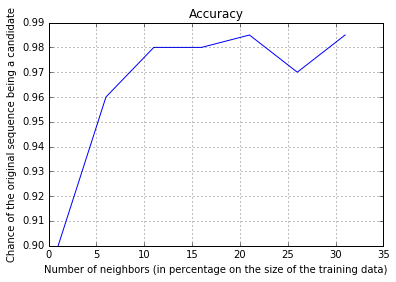

In [1]:
# Adding this snippet so the code can run on osx
from sys import platform as platform_name
if platform_name == "darwin":
   import sys
   sys.path.append('//anaconda/lib/python3.5/site-packages/')

import random
from random import choice

import operator
import os
import math
import time
from string import ascii_uppercase

import matplotlib.pyplot as plt
import itertools
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from numpy import trapz

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KDTree

import threading

import generate_fake_lake as fl

%matplotlib inline


# ****** functions ********

#read n .fna database files in the specified path
#set n = 0 to read all files
def ReadDataBase(_path, n):
    seqList = []
    from os import path
    files = os.listdir(_path) #makes a list of all files in folder
    i = 0
    j = 0
    for f in files:
        for seq_record in SeqIO.parse(_path + f, "fasta"):
            seqList.append(seq_record.seq) # reads each file into a list
            j += 1
            if(n > 0):
                if(j > n-1):
                    i = n
                    break
        i += 1
        j = 0

        if(n > 0):
            if(i > n-1):
                break
    return seqList


#read n .fna database files in the specified path
#set n = 0 to read all files
def ReadDataBaseFilenames(_path, n, filename_filename):
    seqList = []
    filenameList = []
    from os import path
    files = os.listdir(_path) #makes a list of all files in folder
    i = 0
    j = 0
    for f in files:
        for seq_record in SeqIO.parse(_path + f, "fasta"):
            s = seq_record.seq
            seqList.append(s) # reads each file into a list
            filenameList.append(_path + f)
            j += 1
            if(n > 0):
                if(j > n-1):
                    i = n
                    break
        i += 1
        j = 0

        if(n > 0):
            if(i > n-1):
                break

    fid = open(filename_filename, 'w')
    for f in filenameList:
        fid.write(f + '\n')
    fid.close()
    return seqList, filenameList


#creates dictionary with all permutations of length n
#with repetition to index Feature Vector
def CreateDictionary(n):
    chars = "ACGT"
    arr = list(itertools.product(chars, repeat=n))

    D = {}
    i = 0

    for a in arr:
        D[''.join(a)] = i
        i += 1

    return D

#builds the feature vector for sequence using specified indexing dictionary
def FeatureVector(dictionary, sequence, n):
    sLen = len(sequence)
    arr = [0]*4**n
    i = 0
    while(1):
        w = sequence[i:i+n]
        try:
            arr[dictionary[w]] += 1
        except:
            i = i
        i += 1
        if(i+n > sLen):
            break

    return arr

#Reads the DB files and puts the information of the file in a array of strings
def readfile(filename):
    temp = open(filename, 'r').read().split('\n')
    return temp


#returns a random string of specified length
#length: strign length
def randomword(length):
    return (''.join(choice('ACGT') for i in range(0, length)))

#retuns an array of random strings
#size: how many strings there will be in the array
#lakeMinLen: min sequence length
#lakeMaxLen: max sequence length
def lakeString(size, lakeMinLen, lakeMaxLen):
    lake_water = []
    for i in range(0, size):
        random.seed()
        #generates a random sequence length
        y = random.randint(lakeMinLen, lakeMaxLen)

        _str = randomword(y)
        lake_water.append(_str)
    return lake_water


def kdtree(data, lake_matrix, k_neighbors = 10, leaf_size = 20):
    # training
    # kdtree = KDTree(data, leaf_size=leaf_size, metric='minkowski')
    kdtree = KDTree(data, leaf_size=leaf_size, metric='euclidean')

    # testing
    distances, indices = kdtree.query(lake_matrix, k=k_neighbors)
    return np.array(indices), distances


def clustering(data, lake_matrix, num_clusters = 12):
    # training
    estimator = KMeans(n_clusters=num_clusters)
    estimator.fit(data)
    training_labels = estimator.labels_

    clusters = [[]]*num_clusters  # stores the index of the points in each cluster
    for clust in range(0,num_clusters):
        labels_idx = np.where(training_labels == clust)[0]
        clusters[clust] = labels_idx

#     # printing cluster data
#     i = 0
#     for clt in clusters:
#         virs = [c for c in clt if c < len_viruses]
#         perc = len(virs)/len(clt)
#         print("% of virus in cluster ", i, ": ", perc)
#         i += 1

    # testing
    indices = []
    estimated_labels = estimator.predict(lake_matrix)
    for lbl in estimated_labels:
        indices.append(clusters[lbl])

    return np.array(indices)

def check_indices(indices, lake_filenames, filenames, lake_indices):
    right = 0
    cnt = 0

    for i in lake_filenames:
        for ii in indices[cnt]:
            if i == filenames[ii]:
                right += 1
                break
        cnt += 1
    print ("right answers: ", right, " / ", len(lake_filenames))
    return (right / len(lake_filenames))

def listToString(list):
    string = ''
    for ll in list:
        for l in ll:
            string += str(l) + ' '
        string += '\n'
    return string

def filenameToMatrix(file):
    l = []
    fid = open(file,'r')
    for f in fid:
        l.append(f.replace('\n',''))
    return l

def computeFeatureVector(known_bacterias):
    import multiprocessing as mp
    num_thread = multiprocessing.cpu_count()
    matrix = [[]]*len(known_bacterias)
    for i in range(num_thread):
        featureVectorThread(matrix, i, D, w, n)

    n = 4; D = CreateDictionary(n)
    for w in known_bacterias:
        arr = FeatureVector(D, str(w), n)
        arr = np.divide(np.array(arr), len(w))
        m+=1
        if(m%50 == 0):
            print(m,"of", len(known_bacterias))
        bact_matrix.append(arr)
        
def process(virus_filenames, bact_filenames, qtd_virus, qtd_bacteria, use_pca, it):
    # generating lake
    print("generating lake...")
    lake_filenames, lake_indices = fl.Generate_lake(virus_filenames, bact_filenames, qtd_virus, qtd_bacteria)
    lake = readfile("../database/lake.txt")
    num_virus_lake = int(lake[0])
    num_bact_lake = int(lake[1])
    lake = lake[2:]
    
    lake_matrix = []

    n = 4; D = CreateDictionary(n)
    for w in lake:
        arr = FeatureVector(D, str(w), n)
        arr = np.divide(np.array(arr), len(w))
        lake_matrix.append(arr)
    
    len_lake = len(lake)
    len_viruses = len(virus_matrix)

    matrix = np.vstack((virus_matrix,bact_matrix))
    virus_bact_filenames = np.hstack((virus_filenames,bact_filenames))
    
    ###### PCA
    if use_pca:
        print("performing PCA...")
        X = np.array(matrix)
        # PCA input: samples x features
        pca = PCA(n_components=pca_components)
        Xhat = pca.fit_transform(X)
        print("Percentage of represented variance: ", sum(pca.explained_variance_ratio_))
    
    ###### CLASSIFICATION
    if use_pca:
        data = np.array(Xhat)
        lake_matrix = pca.transform(lake_matrix)
    else:
        data = np.array(matrix)
    
    ### choose a classification method
    ## the method will pick the best candidates to perform local alignment in each lake sample
    siz1, siz2 = data.shape
    perc = it/100
    neighbors = round(perc*siz1)
    print("running knn with ", neighbors, " neighbors....")
    
    # classification call
    indices, dist = kdtree(data, lake_matrix, k_neighbors = neighbors, leaf_size = 30)
    
    ###### PRINT ACCURACY
    acc = check_indices(indices, lake_filenames, virus_bact_filenames, lake_indices)
    
    return acc

# ******************************************************* main ****************************************************

use_presaved = False

if use_presaved:
    virus_matrix = np.loadtxt('../presaved/virus_features.txt')
    bact_matrix = np.loadtxt('../presaved/bact_features.txt')
    virus_filenames = filenameToMatrix("../presaved/virus_filenames.txt")
    bact_filenames = filenameToMatrix("../presaved/bact_filenames.txt")
else:
    print("reading data...")
    known_viruses, virus_filenames = ReadDataBaseFilenames("../database/virus/", 0, "../presaved/virus_filenames.txt")
    known_bacterias, bact_filenames = ReadDataBaseFilenames("../database/bact/", 0, "../presaved/bact_filenames.txt")
    virus_matrix = []
    bact_matrix = []
    n = 4; D = CreateDictionary(n)
    print("generating viruses feature vectors...")
    for w in known_viruses:
        arr = FeatureVector(D, str(w), n)
        arr = np.divide(np.array(arr), len(w))
        virus_matrix.append(arr)
    m=0
    print("generating bacterias feature vectors...")
    for w in known_bacterias:
        arr = FeatureVector(D, str(w), n)
        arr = np.divide(np.array(arr), len(w))
        m+=1
        if(m%50 == 0):
            print(m,"of", len(known_bacterias))
        bact_matrix.append(arr)
    # saving feature vectors in file
    fid1 = open('../presaved/virus_features.txt', 'w')
    fid2 = open('../presaved/bact_features.txt', 'w')
    fid1.write(listToString(virus_matrix))
    fid2.write(listToString(bact_matrix))
    fid1.close(); fid2.close()


use_pca = False
pca_components = 50

qtd_virus = 100
qtd_bacteria = 100

x_data = []
y_data = []

for perc in range(1,35,5):
    x_data.append(perc)
    print("===================== ", perc)
    acc = process(virus_filenames, bact_filenames, qtd_virus, qtd_bacteria, use_pca, perc)
    y_data.append(acc)

    

##### PLOTTING ACURACCY TEST
print("x: ", x_data)
print("y: ", y_data)
plt.plot(x_data, y_data)
plt.title('Accuracy')
plt.ylabel('Chance of the original sequence being a candidate')
plt.xlabel('Number of neighbors (in percentage on the size of the training data)')
plt.grid(True)
plt.show()